# Day 7: Week 4 Review & Interview Questions
## Week 4: Machine Learning Foundations

---

**Today's Focus:**
- Review all Week 4 concepts
- Practice interview questions
- Build integrated ML pipeline
- Common pitfalls discussion

In [1]:
# Day 7 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

print("=" * 60)
print("WEEK 4 REVIEW - ML FOUNDATIONS")
print("=" * 60)

WEEK 4 REVIEW - ML FOUNDATIONS


## 📚 Week 4 Concept Summary

### Day 1: Linear Regression
- OLS fundamentals: $\hat{\beta} = (X^TX)^{-1}X^Ty$
- Assumptions: linearity, independence, homoscedasticity, normality
- CAPM beta estimation

### Day 2: Regularization
- Ridge (L2): $\min ||y - X\beta||^2 + \lambda||\beta||_2^2$
- Lasso (L1): $\min ||y - X\beta||^2 + \lambda||\beta||_1$
- ElasticNet: Combines both

### Day 3: Cross-Validation
- Time series CV: Walk-forward, expanding window
- Purging and embargo to prevent leakage

### Day 4: Feature Engineering
- Lagged returns, technical indicators
- Look-ahead bias prevention

### Day 5: Classification
- Binary classification for trading signals
- Threshold optimization

### Day 6: Model Evaluation
- Regression: MSE, MAE, R², IC
- Classification: Precision, Recall, F1, AUC
- Trading metrics: Sharpe, Max DD, Profit Factor

In [8]:
# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)
prices = df[['AAPL', 'MSFT', 'SPY', 'JPM', 'GLD']].dropna()
returns = prices.pct_change().dropna() * 100

print(f"Data: {len(returns)} days, {len(returns.columns)} assets")

Data: 1770 days, 5 assets


## 🎯 Interview Question 1: Bias-Variance Tradeoff

**Q: Explain the bias-variance tradeoff and how regularization helps.**

In [9]:
# Demonstrate bias-variance tradeoff
print("=" * 60)
print("BIAS-VARIANCE TRADEOFF")
print("=" * 60)

# Create features
def create_features(returns, target_col, max_lag=10):
    X = pd.DataFrame(index=returns.index)
    for lag in range(1, max_lag + 1):
        X[f'lag_{lag}'] = returns[target_col].shift(lag)
    for col in returns.columns:
        if col != target_col:
            X[f'{col}_lag1'] = returns[col].shift(1)
    return X.dropna()

X = create_features(returns, 'SPY', max_lag=5)
y = returns['SPY'].loc[X.index]

# Compare models with different regularization
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()

results = []
for alpha in alphas:
    train_scores = []
    test_scores = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)
        
        model = Ridge(alpha=alpha)
        model.fit(X_train_s, y_train)
        
        train_scores.append(r2_score(y_train, model.predict(X_train_s)))
        test_scores.append(r2_score(y_test, model.predict(X_test_s)))
    
    results.append({
        'Alpha': alpha,
        'Train R²': np.mean(train_scores),
        'Test R²': np.mean(test_scores),
        'Gap': np.mean(train_scores) - np.mean(test_scores)
    })

results_df = pd.DataFrame(results)
print("\n📊 Alpha vs Performance:")
print(results_df.to_string(index=False))

print("\n💡 Key Insight:")
print("  - Low alpha: High variance (overfitting), large gap")
print("  - High alpha: High bias (underfitting), poor test score")
print("  - Optimal alpha: Balance between train and test performance")

BIAS-VARIANCE TRADEOFF

📊 Alpha vs Performance:
  Alpha  Train R²   Test R²      Gap
  0.001  0.079687 -0.097807 0.177494
  0.010  0.079687 -0.097803 0.177490
  0.100  0.079687 -0.097766 0.177453
  1.000  0.079684 -0.097395 0.177079
 10.000  0.079495 -0.094032 0.173527
100.000  0.076630 -0.073219 0.149849

💡 Key Insight:
  - Low alpha: High variance (overfitting), large gap
  - High alpha: High bias (underfitting), poor test score
  - Optimal alpha: Balance between train and test performance


## 🎯 Interview Question 2: Why Time Series CV?

**Q: Why can't you use k-fold cross-validation for time series data?**

In [10]:
# Demonstrate look-ahead bias
print("=" * 60)
print("K-FOLD VS TIME SERIES CV")
print("=" * 60)

from sklearn.model_selection import KFold

# K-fold (WRONG for time series)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_scores = []

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    model = Ridge(alpha=1.0)
    model.fit(X_train_s, y_train)
    kfold_scores.append(r2_score(y_test, model.predict(X_test_s)))

# Time series CV (CORRECT)
tscv_scores = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    model = Ridge(alpha=1.0)
    model.fit(X_train_s, y_train)
    tscv_scores.append(r2_score(y_test, model.predict(X_test_s)))

print(f"\n📊 K-Fold CV (WRONG):")
print(f"  Mean R²: {np.mean(kfold_scores):.4f} ± {np.std(kfold_scores):.4f}")

print(f"\n📊 Time Series CV (CORRECT):")
print(f"  Mean R²: {np.mean(tscv_scores):.4f} ± {np.std(tscv_scores):.4f}")

print("\n⚠️ K-Fold inflates performance because:")
print("  1. Future data leaks into training")
print("  2. Serial correlation creates artificial signal")
print("  3. Not realistic trading scenario")

K-FOLD VS TIME SERIES CV

📊 K-Fold CV (WRONG):
  Mean R²: -0.0055 ± 0.0559

📊 Time Series CV (CORRECT):
  Mean R²: -0.0974 ± 0.0651

⚠️ K-Fold inflates performance because:
  1. Future data leaks into training
  2. Serial correlation creates artificial signal
  3. Not realistic trading scenario


## 🎯 Interview Question 3: Feature Importance

**Q: How do you interpret feature importance in Ridge vs. Lasso?**

RIDGE VS LASSO FEATURE IMPORTANCE

Coefficients Comparison:
  Feature     Ridge     Lasso
    lag_1  0.046857 -0.000000
    lag_2  0.095420  0.089081
    lag_3 -0.021228 -0.009050
    lag_4 -0.077338 -0.066384
    lag_5  0.053772  0.045285
AAPL_lag1 -0.115281 -0.097290
MSFT_lag1 -0.053226 -0.029375
 JPM_lag1 -0.138830 -0.115826
 GLD_lag1  0.050168  0.042849

Non-zero coefficients:
  Ridge: 9 of 9
  Lasso: 8 of 9


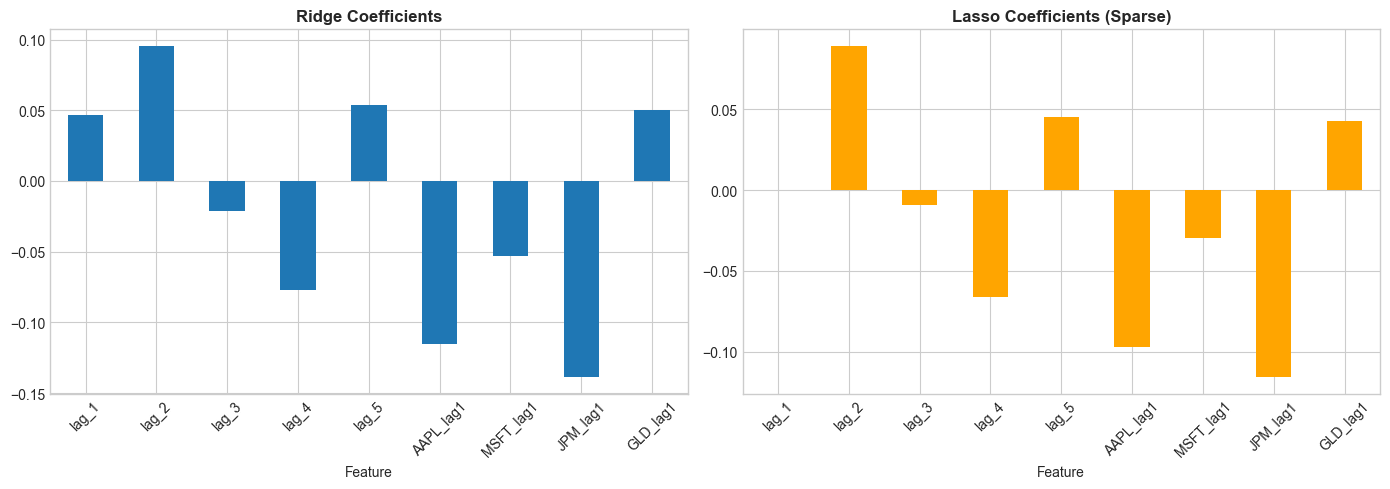


💡 Key Insight:
  - Ridge shrinks ALL coefficients but keeps them non-zero
  - Lasso sets some coefficients exactly to zero (feature selection)
  - Use Lasso when you want sparse, interpretable models


In [11]:
# Compare Ridge vs Lasso feature selection
print("=" * 60)
print("RIDGE VS LASSO FEATURE IMPORTANCE")
print("=" * 60)

# Split data
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Fit both models
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_s, y_train)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_s, y_train)

# Compare coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Ridge': ridge.coef_,
    'Lasso': lasso.coef_
})

print("\nCoefficients Comparison:")
print(coef_df.to_string(index=False))

print(f"\nNon-zero coefficients:")
print(f"  Ridge: {(np.abs(ridge.coef_) > 1e-5).sum()} of {len(ridge.coef_)}")
print(f"  Lasso: {(np.abs(lasso.coef_) > 1e-5).sum()} of {len(lasso.coef_)}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ridge coefficients
coef_df.plot(x='Feature', y='Ridge', kind='bar', ax=axes[0], legend=False)
axes[0].set_title('Ridge Coefficients', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Lasso coefficients
coef_df.plot(x='Feature', y='Lasso', kind='bar', ax=axes[1], legend=False, color='orange')
axes[1].set_title('Lasso Coefficients (Sparse)', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print("  - Ridge shrinks ALL coefficients but keeps them non-zero")
print("  - Lasso sets some coefficients exactly to zero (feature selection)")
print("  - Use Lasso when you want sparse, interpretable models")

## 🎯 Interview Question 4: Complete Pipeline

**Q: Build a complete ML prediction pipeline for trading.**

In [12]:
# Complete ML Pipeline
print("=" * 60)
print("COMPLETE ML TRADING PIPELINE")
print("=" * 60)

class MLTradingPipeline:
    """Complete ML pipeline for trading predictions."""
    
    def __init__(self, model_type='ridge', alpha=1.0):
        self.model_type = model_type
        self.alpha = alpha
        self.scaler = StandardScaler()
        self.model = None
        self.feature_names = None
        
    def create_features(self, prices, returns, target_col):
        """Create feature matrix with proper lag."""
        X = pd.DataFrame(index=returns.index)
        
        # Lagged returns (shift by 1 to avoid look-ahead)
        for lag in range(1, 6):
            X[f'ret_lag_{lag}'] = returns[target_col].shift(lag)
        
        # Volatility
        X['vol_5'] = returns[target_col].rolling(5).std().shift(1)
        X['vol_20'] = returns[target_col].rolling(20).std().shift(1)
        
        # Cross-asset features
        for col in returns.columns:
            if col != target_col:
                X[f'{col}_lag1'] = returns[col].shift(1)
        
        # SMA distance
        p = prices[target_col]
        X['sma_10_dist'] = (p / p.rolling(10).mean() - 1).shift(1)
        X['sma_20_dist'] = (p / p.rolling(20).mean() - 1).shift(1)
        
        self.feature_names = X.columns.tolist()
        return X
    
    def fit(self, X, y):
        """Fit the model."""
        # Select model
        if self.model_type == 'ridge':
            self.model = Ridge(alpha=self.alpha)
        elif self.model_type == 'lasso':
            self.model = Lasso(alpha=self.alpha)
        elif self.model_type == 'rf':
            self.model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
        
        # Scale
        X_scaled = self.scaler.fit_transform(X)
        
        # Fit
        self.model.fit(X_scaled, y)
        return self
    
    def predict(self, X):
        """Generate predictions."""
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)
    
    def backtest(self, X, y, train_window=500, test_window=20):
        """Walk-forward backtest."""
        predictions = []
        actuals = []
        dates = []
        
        for i in range(train_window, len(X) - test_window, test_window):
            # Training data
            X_train = X.iloc[i-train_window:i]
            y_train = y.iloc[i-train_window:i]
            
            # Test data
            X_test = X.iloc[i:i+test_window]
            y_test = y.iloc[i:i+test_window]
            
            # Fit and predict
            self.fit(X_train, y_train)
            preds = self.predict(X_test)
            
            predictions.extend(preds)
            actuals.extend(y_test.values)
            dates.extend(X_test.index)
        
        return pd.DataFrame({
            'date': dates,
            'actual': actuals,
            'predicted': predictions
        })
    
    def evaluate_trading(self, results):
        """Calculate trading metrics."""
        # Position: Long when predict positive
        results['position'] = (results['predicted'] > 0).astype(int)
        results['strategy_return'] = results['position'] * results['actual']
        
        # Metrics
        total_return = (1 + results['strategy_return'] / 100).prod() - 1
        bh_return = (1 + results['actual'] / 100).prod() - 1
        
        ic = np.corrcoef(results['predicted'], results['actual'])[0, 1]
        hit_rate = ((results['predicted'] > 0) == (results['actual'] > 0)).mean()
        
        sharpe = (results['strategy_return'].mean() / results['strategy_return'].std()) * np.sqrt(252)
        
        return {
            'Strategy Return': total_return,
            'Buy & Hold Return': bh_return,
            'Information Coefficient': ic,
            'Hit Rate': hit_rate,
            'Sharpe Ratio': sharpe
        }

# Run pipeline
pipeline = MLTradingPipeline(model_type='ridge', alpha=1.0)
X_full = pipeline.create_features(prices, returns, 'SPY')
y_full = returns['SPY'].loc[X_full.index]

# Clean data
valid_idx = X_full.dropna().index
X_clean = X_full.loc[valid_idx]
y_clean = y_full.loc[valid_idx]

# Backtest
results = pipeline.backtest(X_clean, y_clean)

# Evaluate
metrics = pipeline.evaluate_trading(results)

print("\n📊 Trading Performance:")
for metric, value in metrics.items():
    if 'Return' in metric or 'Rate' in metric:
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")

COMPLETE ML TRADING PIPELINE

📊 Trading Performance:
  Strategy Return: 24.85%
  Buy & Hold Return: 90.69%
  Information Coefficient: -0.0067
  Hit Rate: 50.32%
  Sharpe Ratio: 0.3850


## 📝 Week 4 Interview Cheatsheet

### Key Formulas:

**OLS Solution:** $\hat{\beta} = (X^TX)^{-1}X^Ty$

**Ridge Loss:** $L = ||y - X\beta||^2 + \lambda||\beta||_2^2$

**Lasso Loss:** $L = ||y - X\beta||^2 + \lambda||\beta||_1$

**R-squared:** $R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$

### Common Questions:

1. **"What is multicollinearity and how do you handle it?"**
   - When features are highly correlated
   - Causes unstable coefficient estimates
   - Fix: Remove features, PCA, or use regularization

2. **"Ridge vs Lasso - when to use which?"**
   - Ridge: When all features may be relevant
   - Lasso: When you want sparse feature selection
   - ElasticNet: When unsure

3. **"What is look-ahead bias?"**
   - Using future information in training
   - Common sources: improper lag, survivorship bias, data snooping
   - Prevention: Careful feature engineering, time series CV

4. **"How do you evaluate a trading model?"**
   - Not just accuracy/R²
   - Sharpe ratio, max drawdown, profit factor
   - Out-of-sample walk-forward testing
   - Include transaction costs!

### Red Flags in ML for Trading:
- Very high R² (>0.1 for daily returns)
- Using K-fold CV instead of time series CV
- Not accounting for transaction costs
- Features not properly lagged
- Testing on in-sample period

WEEK 4 SUMMARY VISUALIZATION


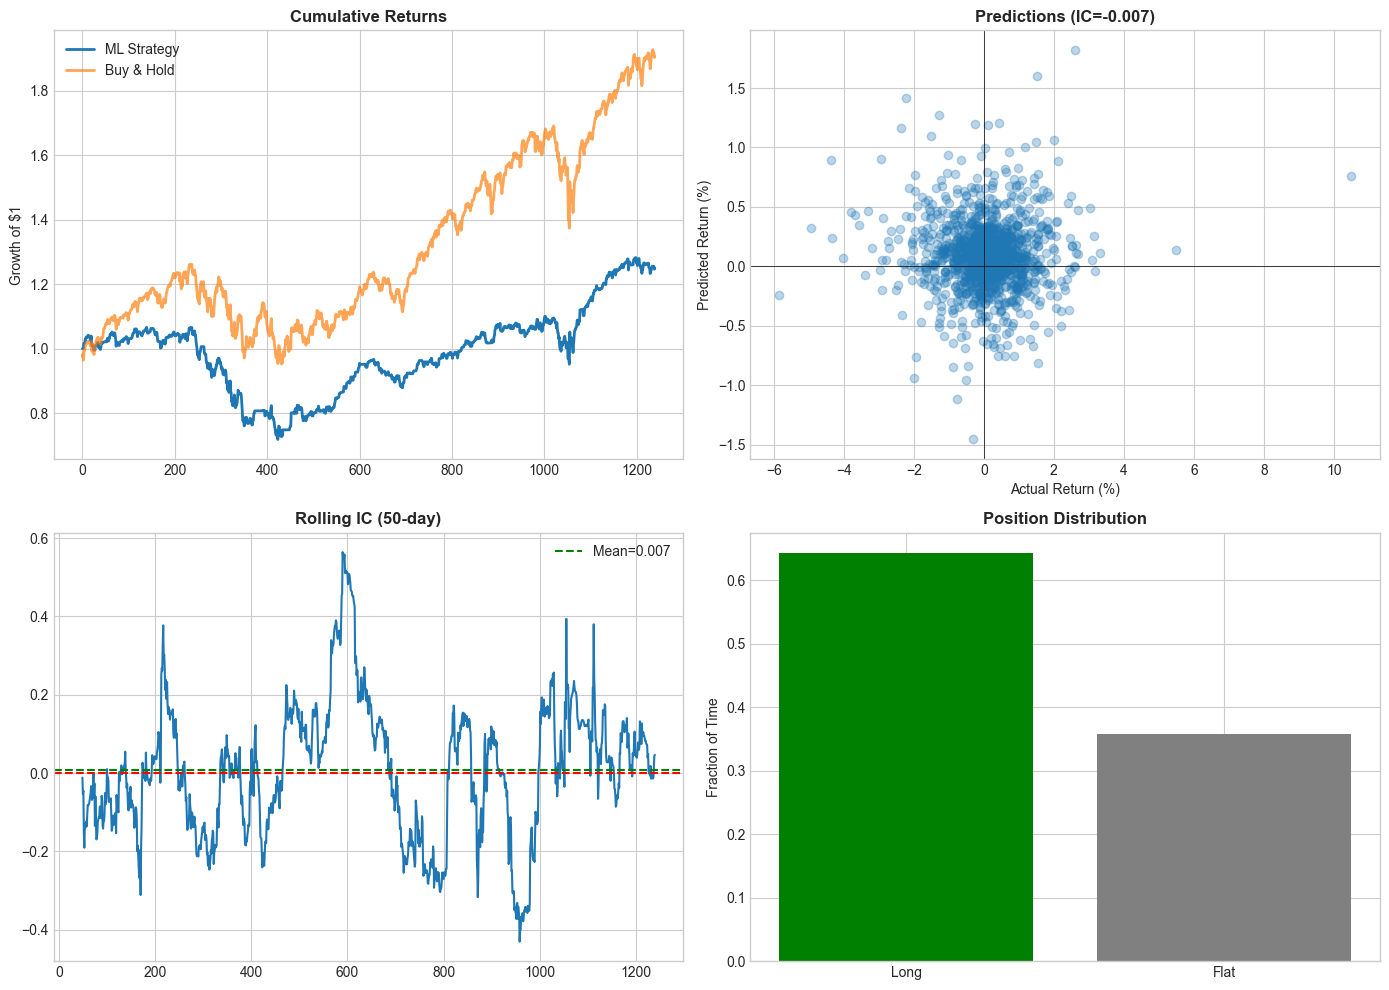


✅ Week 4 Complete!

Next Week: Portfolio Optimization


In [13]:
# Final visualization
print("=" * 60)
print("WEEK 4 SUMMARY VISUALIZATION")
print("=" * 60)

# Strategy cumulative returns
results['cum_strategy'] = (1 + results['strategy_return'] / 100).cumprod()
results['cum_bh'] = (1 + results['actual'] / 100).cumprod()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
axes[0, 0].plot(results['cum_strategy'].values, label='ML Strategy', lw=2)
axes[0, 0].plot(results['cum_bh'].values, label='Buy & Hold', lw=2, alpha=0.7)
axes[0, 0].set_title('Cumulative Returns', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].set_ylabel('Growth of $1')

# Predicted vs Actual scatter
axes[0, 1].scatter(results['actual'], results['predicted'], alpha=0.3)
axes[0, 1].axhline(y=0, color='black', linestyle='-', lw=0.5)
axes[0, 1].axvline(x=0, color='black', linestyle='-', lw=0.5)
axes[0, 1].set_xlabel('Actual Return (%)')
axes[0, 1].set_ylabel('Predicted Return (%)')
axes[0, 1].set_title(f'Predictions (IC={metrics["Information Coefficient"]:.3f})', fontweight='bold')

# Rolling IC
rolling_ic = results['predicted'].rolling(50).corr(results['actual'])
axes[1, 0].plot(rolling_ic.values)
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].axhline(y=rolling_ic.mean(), color='green', linestyle='--', label=f'Mean={rolling_ic.mean():.3f}')
axes[1, 0].set_title('Rolling IC (50-day)', fontweight='bold')
axes[1, 0].legend()

# Position distribution
axes[1, 1].bar(['Long', 'Flat'], 
               [results['position'].mean(), 1 - results['position'].mean()],
               color=['green', 'gray'])
axes[1, 1].set_title('Position Distribution', fontweight='bold')
axes[1, 1].set_ylabel('Fraction of Time')

plt.tight_layout()
plt.show()

print("\n✅ Week 4 Complete!")
print("\nNext Week: Portfolio Optimization")